Code to replicate the results reported for Study 1.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline
%load_ext rpy2.ipython

In [3]:
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

In [4]:
dat = pd.read_csv("responses.csv")
dat.drop(columns=["Unnamed: 0"], inplace=True)

In [5]:
pos_words = [ "joy", "superior", "plentiful", "qualified", "laugh", "famous", 
              "clever", "praise", "sweet", "accurate" 
            ]
neg_words = [ "sorrow", "inferior", "scarce", "unqualified", "cry", "unknown",
              "stupid", "blame", "bitter", "inaccurate"
            ]

In [6]:
response_cols = map(str, range(1,11))
pair_cols = ["pair"+col for col in response_cols]

# Participants

In [7]:
# Comment to include participants who failed the instructional manipulation check
dat = dat.loc[dat.imc_passed]

In [8]:
ddat = dat.loc[dat.party_affil=="Democrat"]
rdat = dat.loc[dat.party_affil=="Republican"]

In [9]:
len(ddat), len(rdat)

(97, 104)

In [10]:
ddat.age.mean(), stats.sem(ddat.age[~np.isnan(ddat.age)]), \
rdat.age.mean(), stats.sem(rdat.age)

(39.90625, 1.198782105382046, 42.52884615384615, 1.2149458793246952)

In [11]:
ddat.gender.value_counts(), rdat.gender.value_counts()

(Female    51
 Male      46
 Name: gender, dtype: int64, Female    62
 Male      42
 Name: gender, dtype: int64)

# Results

In [12]:
dresponses = ddat[response_cols]
dpairs = ddat[pair_cols]
dma = np.ma.masked_where(dpairs.isin(pos_words), dresponses)
dpos = dma.data.copy().astype(float)
dpos[~dma.mask] = np.nan
dneg = dma.data.copy().astype(float)
dneg[dma.mask] = np.nan

In [13]:
rresponses = rdat[response_cols]
rpairs = rdat[pair_cols]
rma = np.ma.masked_where(rpairs.isin(pos_words), rresponses)
rpos = rma.data.copy().astype(float)
rpos[~rma.mask] = np.nan
rneg = rma.data.copy().astype(float)
rneg[rma.mask] = np.nan

Calculate means and standard errors, using the method provided by Arai (2011).

In [15]:
%%R
source("../../conditional-variation/clmclx.R")

In [16]:
%%R
descr.stats <- function(x) {
    y <- c(t(x))
    n <- dim(x)[1]
    k <- dim(x)[2]
    idxn <- rep(1:n, each=k)
    idxn <- idxn[which(!is.na(y))]
    idxk <- rep(1:k, n)
    idxk <- idxk[which(!is.na(y))]
    fit <- lm(y ~ 1)
    res <- mclx(fit, 1, idxn, idxk)
    res[1] <- res[1]
    return (res[1:2])
}

In [17]:
%%R -i dpos -o d_pos_mu,se_dp
ds <- descr.stats(dpos)
d_pos_mu <- ds[1]
se_dp <- ds[2]

In [18]:
print(d_pos_mu, se_dp)

(array([3.1755102]), array([0.18565602]))


In [19]:
%%R -i dneg -o d_neg_mu,se_dn
ds <- descr.stats(dneg)
d_neg_mu <- ds[1]
se_dn <- ds[2]

In [20]:
print(d_neg_mu, se_dn)

(array([4.]), array([0.22030228]))


In [21]:
%%R -i rpos -o r_pos_mu,se_rp
ds <- descr.stats(rpos)
r_pos_mu <- ds[1]
se_rp <- ds[2]

In [22]:
print(r_pos_mu, se_rp)

(array([3.72589792]), array([0.13525356]))


In [23]:
%%R -i rneg -o r_neg_mu,se_rn
ds <- descr.stats(rneg)
r_neg_mu <- ds[1]
se_rn <- ds[2]

In [24]:
print(r_neg_mu, se_rn)

(array([3.02152642]), array([0.12057433]))


A series of $t$-tests (with errors clustered at the participant level).

In [25]:
%%R
options(scipen=999)

clustered.t.test <- function (a, b, matched.participants=FALSE, matched.items=FALSE) {
    y <- c(t(a), t(b))
    n.a <- dim(a)[1]
    n.b <- dim(b)[1]
    k.a <- dim(a)[2]
    k.b <- dim(b)[2]
    stopifnot(k.a == k.b)
    if (matched.participants) {
        stopifnot(n.a == n.b)
        idxn <- c(rep(1:n.a, each=k.a), rep(1:n.b, each=k.b))
    } else {
        idxn <- c(rep(1:n.a, each=k.a), rep((n.a+1):(n.a+n.b), each=k.b))
    }
    idxn <- idxn[which(!is.na(y))]
    if (matched.items) {
        idxk <- rep(1:k.a, n.a+n.b)
    } else {
        idxk <- c(rep(1:k.a, n.a), rep((k.a+1):(k.a+k.b), n.b))
    }
    idxk <- idxk[which(!is.na(y))]
    groups <- c(rep(0, n.a*k.a), rep(1, n.b*k.b))
    fit <- lm(y ~ groups)
    df <- df.residual(fit)
    res <- mclx(fit, 1, idxn, idxk)
    t <- res[2,3]
    p <- res[2,4]
    # Divide p by two for a one-sided test
    return (c(t, df, p/2))
}

Hypothesis: Republicans' judgments on the positive words are higher than Democrats' judgments on the positive words.

In [26]:
%%R
clustered.t.test(dpos, rpos, matched.items=TRUE)

[1]    2.07216636 1017.00000000    0.01925074


Hypothesis: Republicans' judgments on the negative words are lower than Democrats' judgments on the negative words.

In [27]:
%%R
clustered.t.test(dneg, rneg, matched.items=TRUE)

[1]  -3.3099866788 989.0000000000   0.0004833538


Hypothesis: Republicans' judgments on the positive words are higher than Republicans' judgments on the negative words.

In [28]:
%%R
clustered.t.test(rneg, rpos, matched.participants=TRUE)

[1]    3.80896059978 1038.00000000000    0.00007386998


Hypothesis: Democrats' judgments on the positive words are lower than Democrats' judgments on the negative words.

In [29]:
%%R
clustered.t.test(dneg, dpos, matched.participants=TRUE)

[1]  -2.858440775 968.000000000   0.002174304


Figure 1a

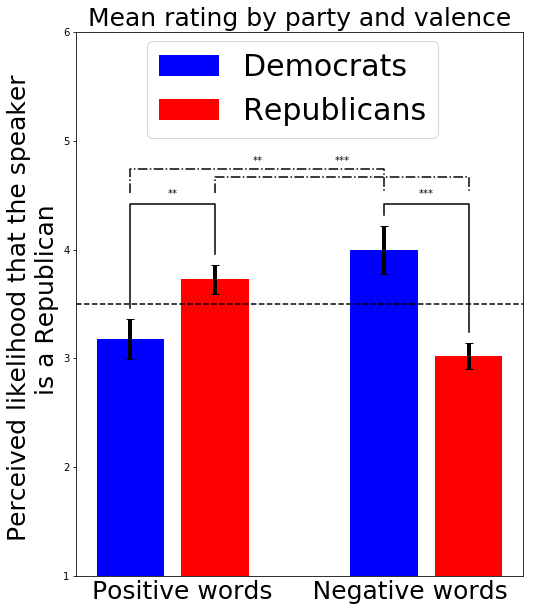

In [30]:
plt.figure(figsize = (8, 10))
mus = np.concatenate([ d_pos_mu, r_pos_mu, d_neg_mu, r_neg_mu ])
sigs = np.concatenate([ se_dp, se_rp, se_dn, se_rn ])
bax = plt.bar([ 1, 2, 4, 5 ], mus, 
              color = [ "blue", "red", "blue", "red" ], 
              yerr = sigs, error_kw = {"linewidth": 4,
              "capsize":4})
plt.ylim([1,6])
xlim = plt.xlim()
plt.xlim(*xlim)
plt.xticks([])
plt.xlabel("Positive words     Negative words", fontsize = 25)
plt.plot(xlim, [3.5, 3.5], "k--")
plt.title("Mean rating by party and valence", fontsize = 25)
heights = mus + sigs
inc = .1
star_height = max(heights) + .2

# Difference between Republicans and Democrats' judgments on the positive words
plt.plot([ 1,1,2,2 ], [ heights[0] + inc, star_height, 
                        star_height, heights[1] + inc],
         linewidth = 1.5, color = "k")
plt.text(1.5, star_height + .05, "**", ha = "center", va = "bottom",
         color = "k")

# Difference between Republicans and Democrats' judgments on the negative words
plt.plot([ 4,4,5,5 ], [ heights[2] + inc, star_height, 
                        star_height, heights[3] + inc],
         linewidth = 1.5, color = "k")
plt.text(4.5, star_height + .05, "***", ha = "center", va = "bottom",
         color = "k")

# Difference between Democrats' judgments on the positive and negative words
plt.plot([ 1,1,4,4 ], [ star_height + .1, star_height + .32,
                        star_height + .32, star_height + .1],
         linestyle = "-.", linewidth = 1.5, color = "k")
plt.text(2.5, star_height + .35, "**", ha = "center", va = "bottom",
         color = "k")

# Difference between Republicans' judgments on the positive and negative words
plt.plot([ 2,2,5,5 ], [ star_height + .1, star_height + .25,
                        star_height + .25, star_height + .1],
         linestyle = "-.", linewidth = 1.5, color = "k")
plt.text(3.5, star_height + .35, "***", ha = "center", va = "bottom",
         color = "k")

plt.legend(bax, ("Democrats", "Republicans"), fontsize=30, loc="center", 
           bbox_to_anchor=(.5, .8),#bbox_to_anchor=(.75, .75),
           bbox_transform=plt.gcf().transFigure, ncol=1)
plt.ylabel("Perceived likelihood that the speaker \n is a Republican", fontsize = 25)
plt.savefig("figure1a")

Regression model

In [31]:
dat.gender = dat.gender.replace({ "Male": 1, "Female": -1 })

In [32]:
ma = np.ma.make_mask(dat[pair_cols].isin(pos_words))
pos = dat.copy()
pos[response_cols] = pos[response_cols].astype(float)
responses = pos[response_cols].values
responses[~ma] = np.nan
pos[response_cols] = responses
neg = dat.copy()
neg[response_cols] = neg[response_cols].astype(float)
responses = neg[response_cols].values
responses[ma] = np.nan
neg[response_cols] = responses

In [33]:
%%R -i pos,neg
library(lmerTest)
library(tidyverse)

options(contrasts=c("contr.sum","contr.poly"))

response.cols <- c(paste0("X", 1:10, ".pos"), paste0("X", 1:10, ".neg"))
demographic.cols <- c("age", "gender", "party_affil", "party_strength",
                      "political_engagement"
                     )

pos <- pos %>%
    as_tibble() %>%
    mutate(ID=1:nrow(.))
neg <- neg %>%
    as_tibble() %>%
    mutate(ID=1:nrow(.)) %>%
    select(ID, 1:10)

df <- pos %>%
    full_join(neg, by=c("ID"), suffix=c(".pos",".neg")) %>%
    filter(party_affil %in% c("Democrat","Republican")) %>%
    select(ID, response.cols, demographic.cols) %>%
    pivot_longer(response.cols, names_to="item", values_to="rating") %>%
    mutate(condition=grepl(".pos", item)) %>%
    mutate(party_affil=ifelse(party_affil=="Republican", sqrt(.5), -sqrt(.5)),
           condition=ifelse(condition, sqrt(.5), -sqrt(.5)),
           age=age-18,
           party_strength=party_strength-1,
           political_engagement=political_engagement-1
          )

fit <- lmer(rating ~ condition * party_affil + (1|ID) + (1|item), data = df)
summary(fit)

Note: Using an external vector in selections is ambiguous.
i Use `all_of(response.cols)` instead of `response.cols` to silence this message.
i See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.
Note: Using an external vector in selections is ambiguous.
i Use `all_of(demographic.cols)` instead of `demographic.cols` to silence this message.
i See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: rating ~ condition * party_affil + (1 | ID) + (1 | item)
   Data: df

REML criterion at convergence: 7047.2

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.34428 -0.76655 -0.00406  0.77124  2.26608 

Random effects:
 Groups   Name        Variance Std.Dev.
 ID       (Intercept) 0.009038 0.09507 
 item     (Intercept) 0.060916 0.24681 
 Residual             1.90

In [34]:
%%R
# +- 2 SE
coef.interact <- summary(fit)$coefficients[4,1]
se.interact <- summary(fit)$coefficients[4,2]
print(c(coef.interact - 2*se.interact, coef.interact + 2*se.interact))

[1] 0.6413659 0.8886910


In [35]:
%%R
null.fit <- lmer(rating ~ condition + party_affil + (1|ID) + (1|item), data = df)
anova(null.fit, fit, test="LRT")

Data: df
Models:
null.fit: rating ~ condition + party_affil + (1 | ID) + (1 | item)
fit: rating ~ condition * party_affil + (1 | ID) + (1 | item)
         npar    AIC    BIC  logLik deviance  Chisq Df            Pr(>Chisq)
null.fit    6 7191.9 7225.5 -3589.9   7179.9                                
fit         7 7046.3 7085.6 -3516.2   7032.3 147.54  1 < 0.00000000000000022
            
null.fit    
fit      ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [36]:
%%R
fit <- lmer(rating ~ condition * party_affil + condition * age + condition * gender + condition * party_affil * party_strength + condition * party_affil * political_engagement + (1|ID) + (1|item), data = df)
summary(fit)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: rating ~ condition * party_affil + condition * age + condition *  
    gender + condition * party_affil * party_strength + condition *  
    party_affil * political_engagement + (1 | ID) + (1 | item)
   Data: df

REML criterion at convergence: 7008.4

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.48622 -0.76507 -0.00375  0.78720  2.65032 

Random effects:
 Groups   Name        Variance  Std.Dev.
 ID       (Intercept) 0.0008983 0.02997 
 item     (Intercept) 0.0643484 0.25367 
 Residual             1.8846791 1.37284 
Number of obs: 1990, groups:  ID, 199; item, 20

Fixed effects:
                                              Estimate  Std. Error          df
(Intercept)                                   3.666965    0.120984  129.075246
condition                                     0.017585    0.170815  206.209401
party_affil                                   0.088168    0.

Generates the dataframe used to create Figure 1b, which can be recreated by running the script fig1b.py.

In [37]:
davb = np.nanmean(dneg, axis=1) - np.nanmean(dpos, axis=1)
ravb = np.nanmean(rpos, axis=1) - np.nanmean(rneg, axis=1)
dspi = ddat.party_strength
rspi = rdat.party_strength
ddpe = ddat.political_engagement
rdpe = rdat.political_engagement
dfigdat = pd.DataFrame(np.concatenate((davb[:,None], dspi[:,None], ddpe[:,None]), axis=1),
                       columns=["avb","spi","dpe"]
                      )
dfigdat["party"] = "D"
rfigdat = pd.DataFrame(np.concatenate((ravb[:,None], rspi[:,None], rdpe[:,None]), axis=1),
                       columns=["avb","spi","dpe"]
                      )
rfigdat["party"] = "R"
figdat = pd.concat((dfigdat,rfigdat))
figdat.to_csv("fig1b.csv")

In [38]:
spi = figdat.spi.values
dpe = figdat.dpe.values
idx = np.where(~(np.isnan(spi) | np.isnan(dpe)))[0]
stats.pearsonr(spi[idx], dpe[idx])

(0.39955992760108694, 4.595845994591799e-09)

In [39]:
avb = figdat.avb.values
navb = len(avb[avb > 0])
n = len(avb)
p = navb / n
se = np.sqrt(p*(1-p)/n)
print(navb, p, p-2*se, p+2*se)

(145, 0.7213930348258707, 0.6581498220453847, 0.7846362476063566)
